# Sheet 6

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse
from sklearn.linear_model import Ridge, LinearRegression

## 2 Estimating Parameter Relevance

We load [`vostok.txt`](data/vostok.txt) which contains data measured from air trappend in ice-cores extracted in Antarctica. Here, it is attempted to estimate the global temperature anomaly given three features: The age of the air, the cabon dioxide concentration and the dust concentration.

In [2]:
with open('data/vostok.txt', 'r') as f:
    lines = f.readlines()
    
# remove header and split lines
lines = [l.split() for l in lines[2:]]

# filter out lines with missing data
lines = [l for l in lines if len(l) == 4]

# convert to float
lines = np.array(lines).astype(np.float32)
print(f'{lines.shape=}')

features = np.concatenate([lines[:, :1], lines[:, 2:]], axis=1).T
feature_names = 'age', 'CO₂', 'dust'
labels = lines[:, 1]
label_name = '∆T'

print(f'{features.shape=}, {labels.shape=}')

lines.shape=(3729, 4)
features.shape=(3, 3729), labels.shape=(3729,)


We apply a simple linear regression model to the data, minimizing the sum of squares.

In [47]:
from sklearn.linear_model import LinearRegression

# TODO: fit the linear regressor and compute the sum of square deviations
reg = LinearRegression().fit(X=features.T, y=labels.T)
preds = reg.predict(features.T)
sls = np.sum((preds-labels)**2)

print(f'{sls=}')


sls=6362.9375


We can estimate parameter relevance by the *permutation test*, that is to test whether the i-th feature is relevant, we randomly permute the data along its axis. Formally, for a data matrix $\mathbf{X} \in \mathbb{R}^{p \times N}$, we obtain a new data matrix $\tilde{\mathbf{X}}$ by setting $\tilde{\mathbf{X}}_i = \pi (\mathbf{X}_i)$, such that the $i$-th row is permuted via a permutation $\pi$.
Small differences compared to the original SSqs indicates a more irrelevant feature. We repeat this procedure to minimize statistical errors.

In [46]:
# TODO: for each feature, randomly permute it amongst the samples, 
#       refit the regressor and compte sum of squared deviations
ITERS = 50
n = features.shape[0]

ssqs = np.zeros((ITERS, n))
for i in range(ITERS):
    for j in range(n):
        X_tilde = np.copy(features)
        pi_x = np.random.permutation(X_tilde[j])
        X_tilde[j] = pi_x 

        reg = LinearRegression().fit(X=X_tilde.T, y=labels.T)
        preds = reg.predict(X_tilde.T)
        ssqs[i,j] = np.sum((preds-labels)**2)

mean_ssqs = ssqs.mean(axis=0)
diffs = mean_ssqs - sls
m = diffs.argmax()
print(f'Permuting the features leads to difference in SSqs of {diffs}')
print(f'This procedure thus assumes {feature_names[m]} to be the most important feature.')

    

Permuting the features leads to difference in SSqs of [  453.2253125 12805.01375     163.4540918]
This procedure thus assumes CO₂ to be the most important feature


## 4 Visualize Regularization Contours

In [49]:
# load the data
data = np.load('data/linreg.npz')
x = data['X']
y = data['Y']
print(f'{x.shape} {y.shape}')

(2, 100) (1, 100)


In [50]:
# Ridge
def beta_ridge(X,Y,lamb):
    p = X.shape[0]
    reg_scatter = X @ X.T + lamb*np.identity(p)
    beta = np.linalg.inv(reg_scatter) @  X @ Y.T
    return beta

In [54]:
# Lasso
# In general there's no closed form solution for Lasso
# even though there is one in the univariate case

from sklearn.linear_model import Lasso

def beta_lasso(X,Y,alpha=1):
    las = Lasso(alpha)
    las.fit(x.T,y.T)
    beta_lasso = las.coef_
    return beta_lasso



array([0.04926729, 1.07007538])

In [51]:
beta_ridge(x,y,1)

array([[0.98195211],
       [1.97439157]])

In [71]:
np.hstack((beta1, beta2)).shape

(100, 200)

In [87]:
# TODO: create a grid of points in the parameter space
betas = np.linspace(-1,3,100)
beta1, beta2 = np.meshgrid(betas, betas)

reg_lasso = (np.abs(beta1) + np.abs(beta2))
reg_ridge = (beta1**2 + beta2**2)

(a)

[Text(0.5, 0, '$\\beta_1$'), Text(0, 0.5, '$\\beta_2$')]

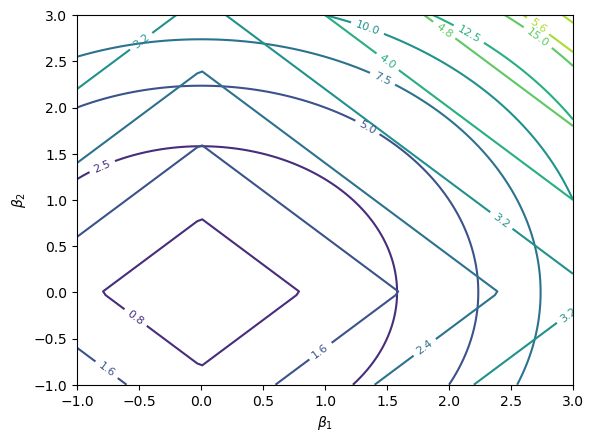

In [172]:
# TODO: make coutour plots for ridge and lasso regularization terms
fig, ax = plt.subplots()
ridge_contours = ax.contour(beta1, beta2, reg_ridge)
lasso_contours = ax.contour(beta1, beta2, reg_lasso)

ax.clabel(ridge_contours, inline=True, fontsize=8)
ax.clabel(lasso_contours, inline=True, fontsize=8)
ax.set(xlabel=r'$\beta_1$', ylabel=r'$\beta_2$')

(b)

[Text(0.5, 0, '$\\beta_1$'), Text(0, 0.5, '$\\beta_2$')]

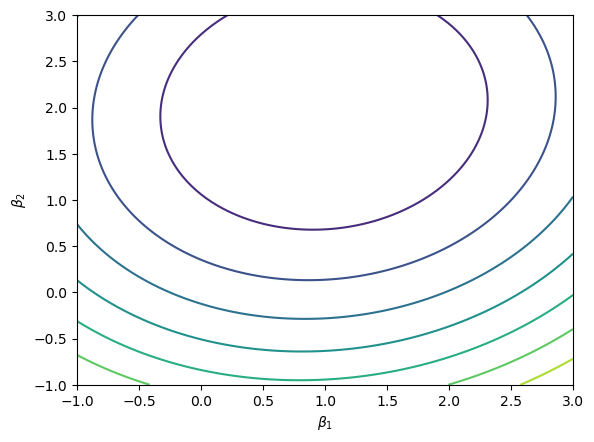

In [171]:
# TODO: for each combination of parameters, compute the sum of squared deviations.
#       do not use loops, but numpy broadcasting!

preds = beta1[np.newaxis, :, :] * x[0,:,np.newaxis, np.newaxis] + beta2[np.newaxis, :, :] * x[1, :, np.newaxis, np.newaxis]
ones = np.ones([len(beta1), len(beta2)])
ys = ones[np.newaxis, :, :] * y[0, :, np.newaxis, np.newaxis]
res = np.sum((ys - preds)**2, axis=0)
assert res.shape == beta1.shape

# TODO: make a contour plot for sum of squared deviations
fig, ax = plt.subplots()
ssq_contours = ax.contour(beta1, beta2, res)
ax.set(xlabel=r'$\beta_1$', ylabel=r'$\beta_2$')

(c)

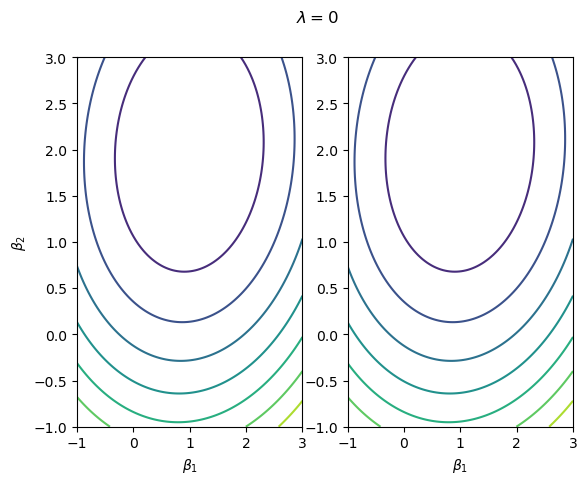

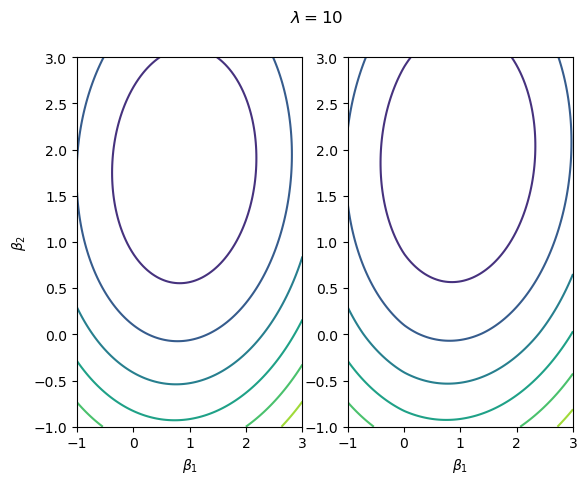

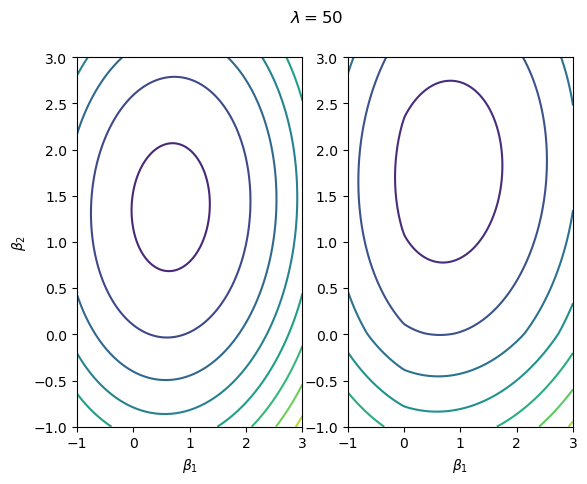

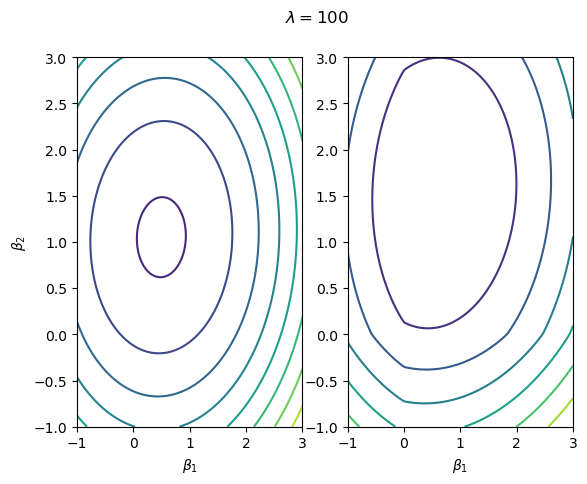

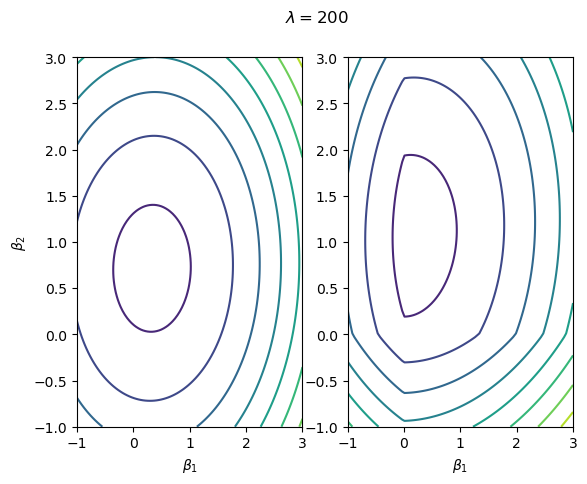

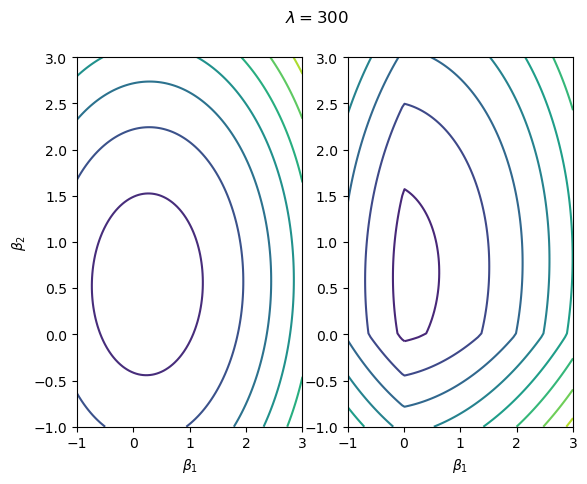

In [179]:
# TODO: for each lambda, plot both ridge regression and lasso loss functions
lambdas = [0, 10, 50, 100, 200, 300]
L2 = beta1**2 + beta2**2
L1 = np.abs(beta1) + np.abs(beta2)

for lamb in lambdas:
    ridge = res + lamb * L2
    lass  = res + lamb * L1

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'$\lambda = {lamb}$')    
    r_contours = ax1.contour(beta1, beta2, ridge)
    ax1.set(xlabel=r'$\beta_1$', ylabel=r'$\beta_2$')

    l_contours = ax2.contour(beta1, beta2, lass)
    ax2.set(xlabel=r'$\beta_1$')
    
    


With $\lambda$ increasing, we shrink the parameters more and more. This leads the coefficients related to a minimal loss to being centered around the origin. <br>
With greater shrinkage, the shape of the lasso regularization term becomes more visible, too. The sum of SSQ (a parabola) and the $L_1$ regularization term results in a parabola in every orthant. <br>
Furthermore, the Lasso objective is continuous but generally not differentiable at $\beta_i \rightarrow 0$.

## CT

set up design matrix (run this once to save to disk)

In [180]:
# create design matrix
# run once to create and save the design matrix
import os

if not os.path.exists('data/design_matrix.npy'):
    res = (99, 117)
    xs = np.arange(0, res[1]+1) - res[1]/2 # np.linspace(-1, 1, res[1] + 1)
    ys = np.arange(0, res[0]+1) - res[0]/2 #np.linspace(-1, 1, res[0] + 1)

    # rays are defined by origin and direction
    n_parallel_rays = 70 
    ray_offset_range = [-res[1]/1.5, res[1]/1.5]
    n_ray_angles = 30
    n_rays = n_parallel_rays * n_ray_angles

    ray_angles = np.linspace(0, np.pi, n_ray_angles, endpoint=False) + np.pi/n_ray_angles
    
    # offsets for ray_angle = 0, i.e. parallel to x-axis
    ray_0_offsets = np.stack([np.zeros(n_parallel_rays), np.linspace(*ray_offset_range, n_parallel_rays)], axis=-1)
    ray_0_directions = np.stack([np.ones(n_parallel_rays), np.zeros(n_parallel_rays)], axis=-1)

    def rot_mat(angle):
        c, s = np.cos(angle), np.sin(angle)
        return np.stack([np.stack([c, s], axis=-1), np.stack([-s, c], axis=-1)], axis=-1)

    ray_rot_mats = rot_mat(ray_angles)

    ray_offsets = np.einsum('oi,aij->aoj', ray_0_offsets, ray_rot_mats).reshape(-1, 2)
    ray_directions = np.einsum('oi,aij->aoj', ray_0_directions, ray_rot_mats).reshape(-1, 2)

    sigma = 1
    kernel = lambda x: np.exp(-x**2/sigma**2/2)

    xsc = (xs[1:] + xs[:-1]) / 2
    ysc = (ys[1:] + ys[:-1]) / 2
    b = np.stack(np.meshgrid(xsc, ysc), axis=-1).reshape(-1, 2)
    a = ray_offsets
    v = ray_directions
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    p = ((b[None] - a[:, None]) * v[:, None]).sum(-1, keepdims=True) * v[:, None] + a[:, None]
    d = np.linalg.norm(b - p, axis=-1)
    d = kernel(d)
    design_matrix = d.T

    np.save('data/design_matrix.npy', design_matrix)
    print(f'created and saved design matrix of shape {design_matrix.shape} at data/design_matrix.npy')

created and saved design matrix of shape (11583, 2100) at data/design_matrix.npy


(a)

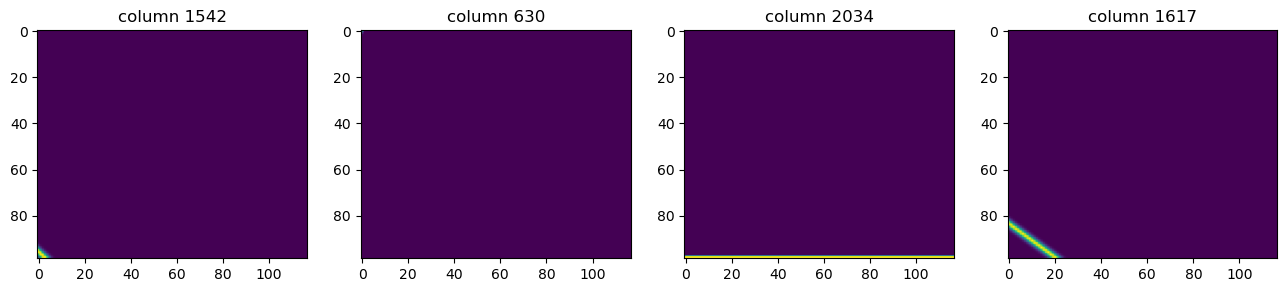

In [2]:
design_matrix = np.load('data/design_matrix.npy')

# TODO: visualize four random columns as images, using an image shape of (99, 117)

img_shape = (99, 117)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in zip(np.random.choice(np.arange(design_matrix.shape[1]), 4), axs):
    ax.imshow(design_matrix[:, i].reshape(*img_shape));
    ax.set_title(f'column {i}')
    
# TODO: interpret what you see

The design matrix $\mathbf{X}$ holds the information, how much every of the $p$ pixels is intersected by one of the $ar$ rays. One of the columns is therefore the flattened pixel array, which we can reshape in to a 2D image. <br>
The (reshaped) image of column $j$ thus shows us, how the $j$'th ray intersects the 2D image.

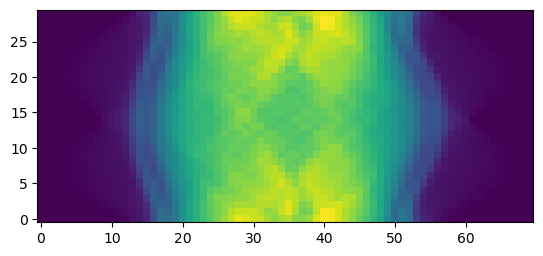

In [3]:
sino = np.load('data/sino.npy')

# visualize sinogram as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(sino.reshape(n_angles, n_parallel_rays), origin='lower')
plt.show();

(b)

For simple linear regression, we estimate the coefficients by 
$$ \hat{\beta} = (XX^T)^{-1} XY^T $$

In [11]:
# TODO: solve the reconstruction with linear regression and visualize the result
X = design_matrix.copy()
Y = sino.copy()

beta = np.linalg.inv(X@X.T) @ X @ Y.T

In [13]:
pred = beta.T @ X

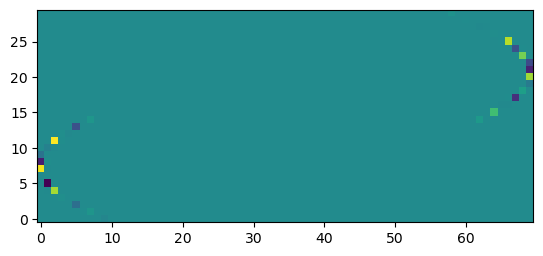

In [15]:
# visualize prediction as image
n_parallel_rays = 70
n_angles = 30
plt.imshow(pred.reshape(n_angles, n_parallel_rays), origin='lower')
plt.show();

In [17]:
# TODO: solve the reconstruction with ridge regression and visualize the result
# Optional: try out different regularization strengths and oberve the influence
# Ridge
def beta_ridge(X,Y,lamb):
    p = X.shape[0]
    reg_scatter = X @ X.T + lamb*np.identity(p)
    beta = np.linalg.inv(reg_scatter) @  X @ Y.T
    return beta

In [21]:
betas = []
for lamb in [1, 10, 50, 100, 200, 300]:
    beta_tst = beta_ridge(X, Y, lamb)
    betas.append(beta_tst)

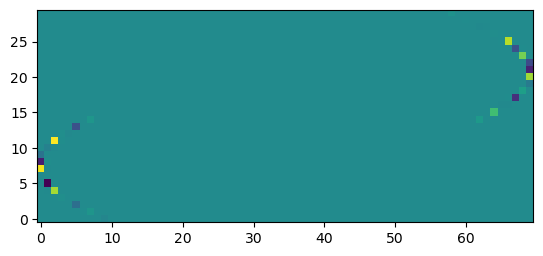

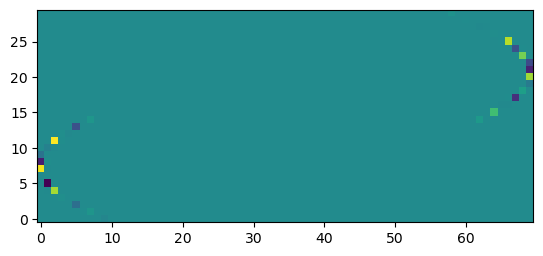

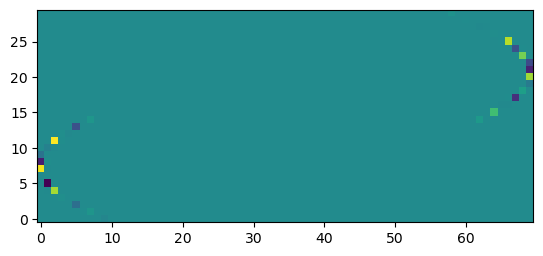

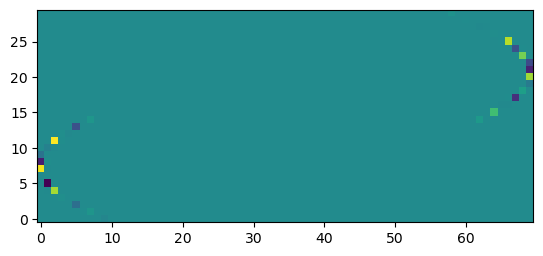

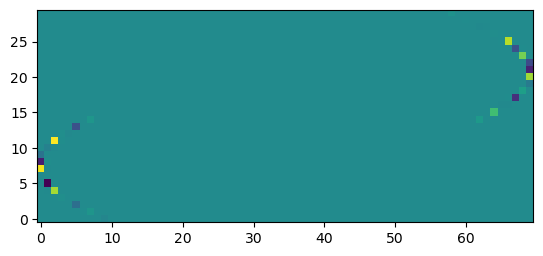

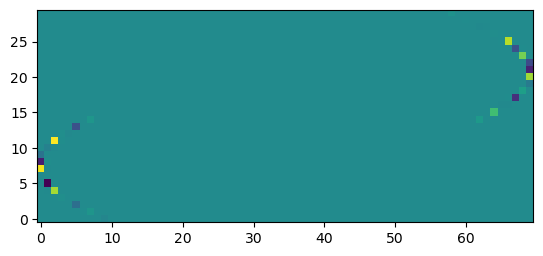

In [22]:
for beta in betas:

    pred_tst = beta.T @ X
    n_parallel_rays = 70
    n_angles = 30
    plt.imshow(pred.reshape(n_angles, n_parallel_rays), origin='lower')
    plt.show();

In [26]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1)
clf.fit(X.T,Y.T)

Ridge(alpha=1)

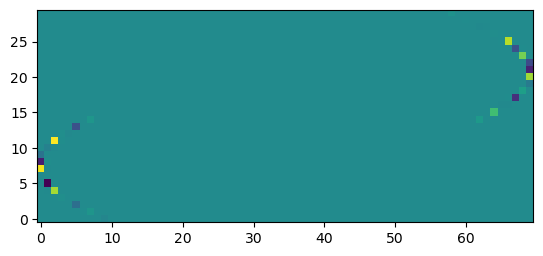

In [30]:
beta_sk = clf.coef_

pred_sk = beta_sk @ X
n_parallel_rays = 70
n_angles = 30
plt.imshow(pred.reshape(n_angles, n_parallel_rays), origin='lower')
plt.show();
